# Siamese_tpxtech　テスト

## 目的
Siamese Networkを使用してtpxtech(印刷画像)の多値分類問題を解けるかを試す.

## 対象画像

- ラベル数：　4(dust, friction, hair, pinhole)
- 画像サイズ：　(height, width, channel) = (80, 80, 3)
- ペア数：　4ラベル合計952ペア(元画像, 各エラー画像のペアに対して1つのラベルが付与されている)

## 実験

### 1. Siamese Networkをそのまま使用して距離学習ができるか

- ペア画像をconcatinateし6チャネル化
- ラベルのposi/negaペアを生成し、距離学習を試す

確認したいこと  
- シンプルに距離で分類ができるほど学習が進むか
- 例えば未分類ラベルの画像で推論をかけたときに「どれにも近くない」のような結果を出すことができるか(要するに、新規ラベルの特定ができるか)

今週の結論

- うまく学習が進まない

### 2. ペア画像をSiameseに入れて, 距離によって多値分類をすることができるか

- ペア画像をSiameseの両inputから投入する
- 最後の出力をsoftmaxにし,距離の違いによって多値分類をすることができるか試す

確認したいこと
- Siameseの出力層を調整することで分類にそのまま使用することができるか

今週の結論

- 学習が進行したのは以下の条件
  - SiameseNetのConvolutonの深さは前回の実装と同じ(深くすると進まない)
  - SiameseNet最後の1次元に展開するレイヤをGlobalAveragePoolingではなくFlatten + Denseにする
  - 出力層をsoftmax,合わせてloss functionをcategorical cross entropyにする
  - データ拡張(90, 180度回転)
- 90%前後で学習が止まる


ーーーーーーーーーーーーー
# 1. Siamese Networkをそのまま使用して距離学習ができるか

In [2]:
# セットアップ

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Dropout,GlobalAveragePooling2D, MaxPool2D, Concatenate, BatchNormalization, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

class_word = ['dust', 'friction', 'hair', 'pinhole']
IMG_SHAPE = (80, 80, 6)
BATCH_SIZE = 16

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [3]:
# GPU動作確認
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
def get_dataset_slice_paths(image_dir, k):
  '''
  画像のパスリストを返す
  '''
  image_file_list = os.listdir(image_dir + k)
  image_paths = [os.path.join(image_dir+k, fname) for fname in image_file_list]

  return image_paths


In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# 画像のペアの6チャネル化
train_data = []
train_label = []

for i, k in enumerate(class_word):
    training_image_paths = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
    training_image_paths.sort()
    print(training_image_paths[:10])
    cnt = 0
    for j in range(0, len(training_image_paths), 2):
        im = np.array(Image.open(training_image_paths[j]))
        im2 = np.array(Image.open(training_image_paths[j + 1]))
        im_concat = np.concatenate([im, im2], 2)
        im_concat = im_concat.tolist()
        train_data.append(im_concat)
        cnt += 1
    train_label.extend([i for m in range(cnt)])


['/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000001.png']
['/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000001.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m_000

In [8]:
train_data = np.array(train_data)
train_label = np.array(train_label)
train_data.shape,  train_label.shape

((952, 80, 80, 6), (952,))

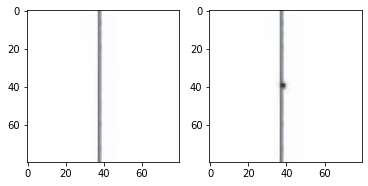

In [9]:
n = np.random.randint(0, 100)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(train_data[n, :, :, :3])
plt.subplot(1, 2, 2)
plt.imshow(train_data[n, :, :, 3:])

In [10]:
# ペアの生成

def make_pairs(images, labels):
    pairImage = []
    pairLabel = []
    CLASS = 4
    label_idx = [np.where(labels == i)[0] for i in range(CLASS)]
    
    for idx in range(len(images)):
        current = images[idx]
        label = labels[idx]
        
        # ポジティブ
        for i in range(1):
          idx_posi = np.random.choice(label_idx[label])
          img_posi = images[idx_posi]
          pairImage.append([current, img_posi])
          pairLabel.append([1])
        
        # ネガティブ
        for j in range(1):
          neg = np.where(labels != label)[0]
          idx_neg = np.random.choice(neg)
          img_neg = images[idx_neg]
          pairImage.append([current, img_neg])
          pairLabel.append([0])

        # # 10C2のペアを作成 => 重いのでペンディング
        # for pair_idx in range(idx+1, len(images)):
        #   pair_img = images[pair_idx]
        #   pair_label = labels[pair_idx]
        #   pairImage.append([current, pair_img])
        #   if label == pair_label:
        #     pairLabel.append([1])
        #   else:
        #     pairLabel.append([0])

        
    # ランダムに並び替える
    per = np.random.permutation(np.arange(len(images)*2))
    pairImage = np.array(pairImage)
    pairImage = pairImage[per]
    
    pairLabel = np.array(pairLabel)
    pairLabel = pairLabel[per]
    
    # テスト、バリデーションに分割して返す

    xData_train, xData_test, yData_train, yData_test = train_test_split(pairImage, pairLabel, test_size=0.2)
    
    return (xData_train, xData_test, yData_train, yData_test)
    
        

In [11]:
xData_train, xData_test, yData_train, yData_test = make_pairs(train_data, train_label)

In [12]:
xData_train.shape, xData_test.shape, yData_train.shape, yData_test.shape

((1523, 2, 80, 80, 6), (381, 2, 80, 80, 6), (1523, 1), (381, 1))

In [13]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooled_output = GlobalAveragePooling2D()(x)
    # pooled_output = Flatten()(x)
    outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, outputs)
    return model

model = build_siamese_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 64)        1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 64)        0     

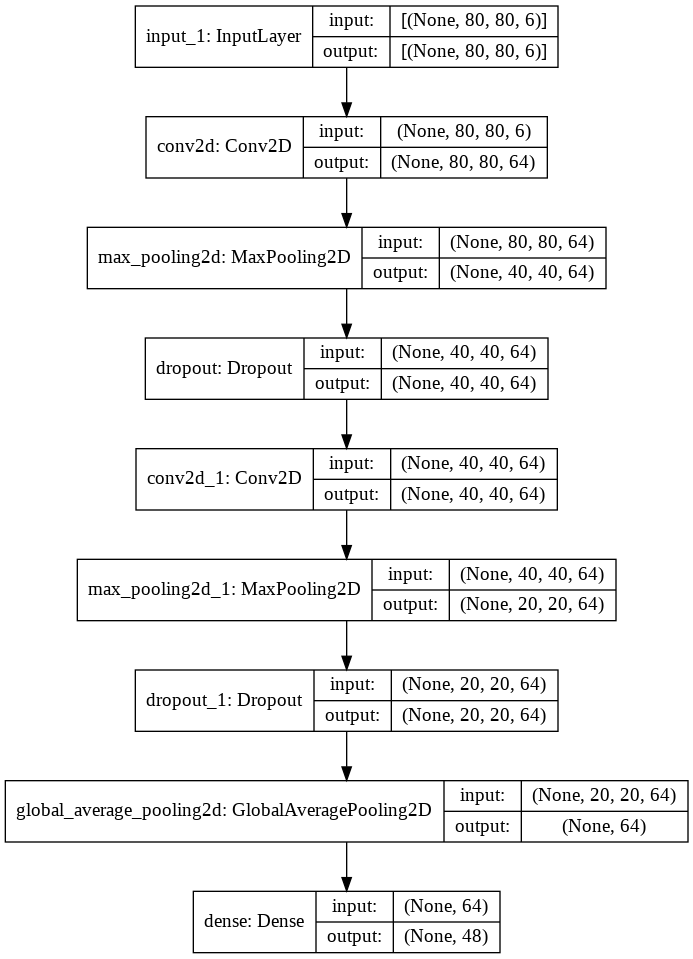

In [14]:
plot_model(model, show_shapes=True)

In [15]:
# １つのインスタンスを共有することでパラメータを共有する

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)


In [16]:
# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.sum(K.square(A - B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(1, activation='sigmoid')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 6)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80, 80, 6)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 48)           21168       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_1[0][0]              

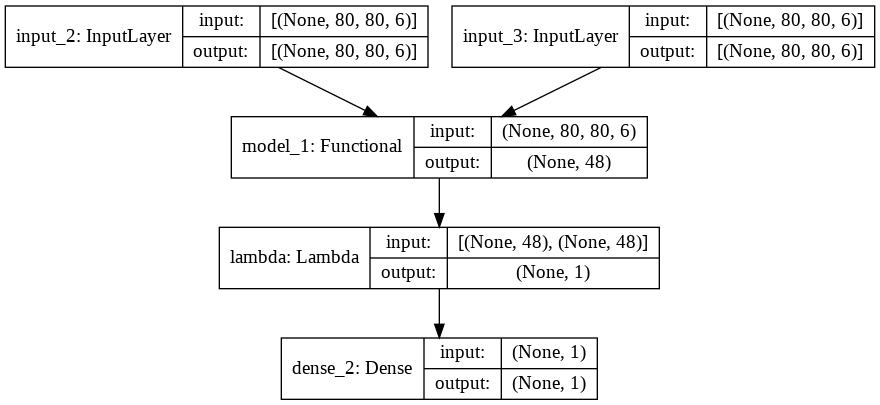

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [19]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y*squaredPreds + (1 - y)*squaredMargin)
    return loss

In [20]:
# 0に近い方場合同一として判定

def dist_accuracy(y, preds):
    return K.mean(K.equal(y, K.cast(preds < 0.5, y.dtype)))

In [21]:
# binary_crossentropyの方が簡単に試せる
model.compile(
    loss = contrastive_loss,
    optimizer = 'adam',
    metrics = [dist_accuracy]
)

In [22]:

def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['dist_accuracy'], label='train acc')
    plt.plot(history.history['val_dist_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

In [23]:
history = model.fit(
    [xData_train[:,0], xData_train[:,1]], yData_train[:],
    validation_data=([xData_test[:,0], xData_test[:,1]], yData_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=5)
)

Epoch 1/100
96/96 [==============================] - 34s 343ms/step - loss: 0.5019 - dist_accuracy: 0.4981 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 2/100
96/96 [==============================] - 33s 345ms/step - loss: 0.4851 - dist_accuracy: 0.5150 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 3/100
96/96 [==============================] - 33s 346ms/step - loss: 0.5207 - dist_accuracy: 0.4794 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 4/100
96/96 [==============================] - 33s 347ms/step - loss: 0.4954 - dist_accuracy: 0.5045 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 5/100
96/96 [==============================] - 33s 348ms/step - loss: 0.5190 - dist_accuracy: 0.4810 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 6/100
96/96 [==============================] - 33s 344ms/step - loss: 0.4931 - dist_accuracy: 0.5069 - val_loss: 0.4776 - val_dist_accuracy: 0.5236
Epoch 7/100
96/96 [==============================] - 33s 344ms/step - loss: 

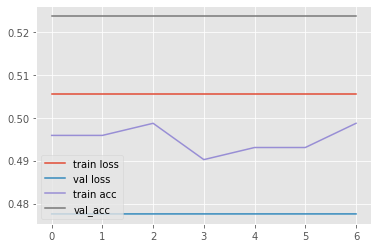

In [24]:
plot_training(history)

ーーーーーーーーーーーーー
# 2. ペア画像をSiameseに入れて, 距離によって多値分類をすることができるか

## 試してみたこと
- 1つの値としての距離を出し、それによる分類：学習進まず
- 距離算出のときにノードを別々に出力(48ノードのまま次に渡す)
  - その後にDense層を噛ませてみる
- Siameseの畳み込みそうを深くする：学習進まず
- 2つのモデルをConcatinateで接続する：早い段階で収束
- 先に2つの画像の距離を出してしまい、分類の学習
- GlobalAveragePooling => Flatten + Dense(正則化)に変えてみる
- optimizerをAdamからRMSPropに

In [25]:

# x:[元画像, エラー画像]のペア y:ラベルのone hot表現を作る

train_data = []
train_label = []

for i, k in enumerate(class_word):
  training_image_path = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
  training_image_path.sort()
  for j in range(0, len(training_image_path), 2):
    im1 = np.array(Image.open(training_image_path[j]))
    im2 = np.array(Image.open(training_image_path[j+1]))
    train_data.append([im1, im2])
    one_hot = [1 if m == i else 0 for m in range(4)]
    train_label.append(one_hot)
  

In [26]:
train_data = np.array(train_data)
train_label = np.array(train_label)

train_data.shape, train_label.shape

((952, 2, 80, 80, 3), (952, 4))

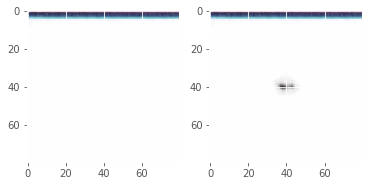

In [27]:
n = np.random.randint(0, 100)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(train_data[n, 0])
plt.subplot(1, 2, 2)
plt.imshow(train_data[n, 1])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.2)
x_train, x_test = x_train/255.0, x_test/255.0

In [29]:
train = []
label = []
for i in range(len(x_train)):
  train.append(x_train[i])
  train.append([np.rot90(x_train[i,0]), np.rot90(x_train[i,1])])
  train.append([np.rot90(x_train[i,0], 2), np.rot90(x_train[i,1], 2)])
  label.append(y_train[i])
  label.append(y_train[i])
  label.append(y_train[i])
x_train = np.array(train)
y_train = np.array(label)

x_train.shape, y_train.shape

((2283, 2, 80, 80, 3), (2283, 4))

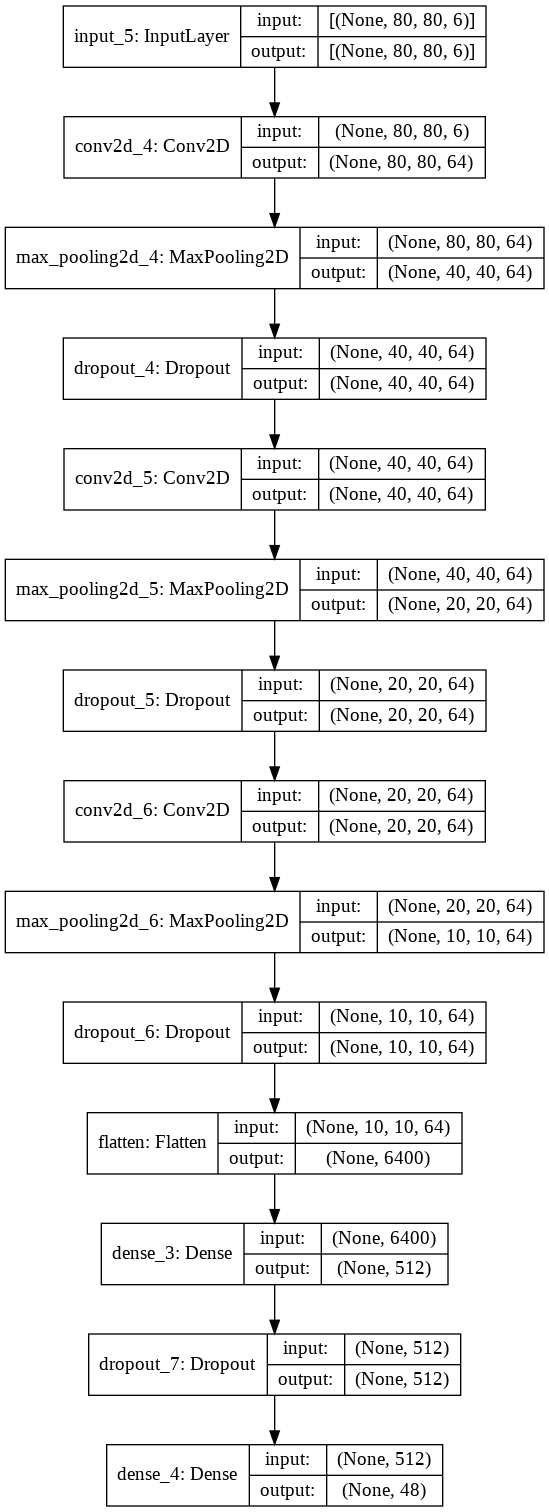

In [30]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooled_output = Flatten()(x)
    pooled_output = Dense(512, kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu')(pooled_output)
    pooled_output = Dropout(0.3)(pooled_output)
    outputs = Dense(output_dim, kernel_regularizer = tf.keras.regularizers.l2(0.001))(pooled_output)
    
    model = Model(inputs, outputs)
    return model

model = build_siamese_model(IMG_SHAPE)
plot_model(model, show_shapes=True)

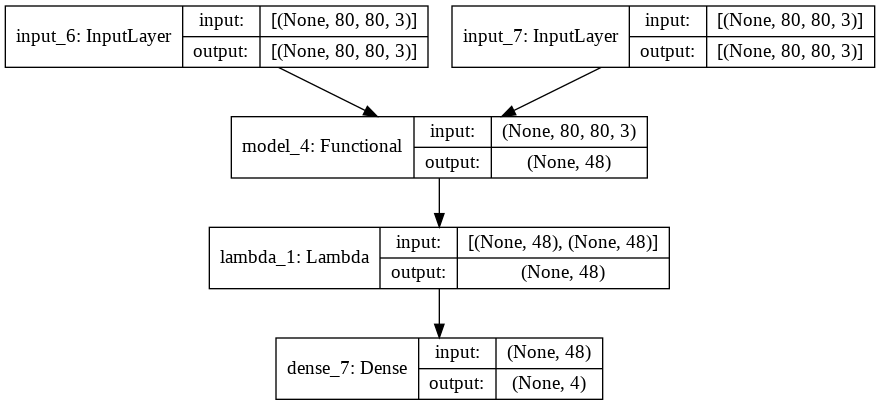

In [31]:

IMG_SHAPE = (80, 80, 3)

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

def euclidean_distance(vectors):
    (A, B) = vectors
    Squared = K.square(A - B)
    return K.sqrt(K.maximum(Squared, K.epsilon()))

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)
dist = Lambda(euclidean_distance)([modelA, modelB])
# dist = Concatenate()([modelA, modelB])
outputs = Dense(4, activation='softmax')(dist) # 強引に多値分類にしてみる
model = Model(inputs=[imgA, imgB], outputs=outputs)

plot_model(model, show_shapes=True)

In [32]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [33]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
)

Epoch 1/100
143/143 [==============================] - 61s 419ms/step - loss: 1.9493 - accuracy: 0.5416 - val_loss: 1.5781 - val_accuracy: 0.5916
Epoch 2/100
143/143 [==============================] - 59s 415ms/step - loss: 1.1540 - accuracy: 0.6080 - val_loss: 1.4389 - val_accuracy: 0.5916
Epoch 3/100
143/143 [==============================] - 59s 415ms/step - loss: 1.0341 - accuracy: 0.6267 - val_loss: 1.4020 - val_accuracy: 0.5916
Epoch 4/100
143/143 [==============================] - 59s 414ms/step - loss: 0.9954 - accuracy: 0.6396 - val_loss: 1.3746 - val_accuracy: 0.5916
Epoch 5/100
143/143 [==============================] - 59s 413ms/step - loss: 0.9582 - accuracy: 0.6420 - val_loss: 1.3641 - val_accuracy: 0.5916
Epoch 6/100
143/143 [==============================] - 59s 413ms/step - loss: 0.9838 - accuracy: 0.6276 - val_loss: 1.3537 - val_accuracy: 0.5916
Epoch 7/100
143/143 [==============================] - 60s 419ms/step - loss: 0.9791 - accuracy: 0.6201 - val_loss: 1.3481 -

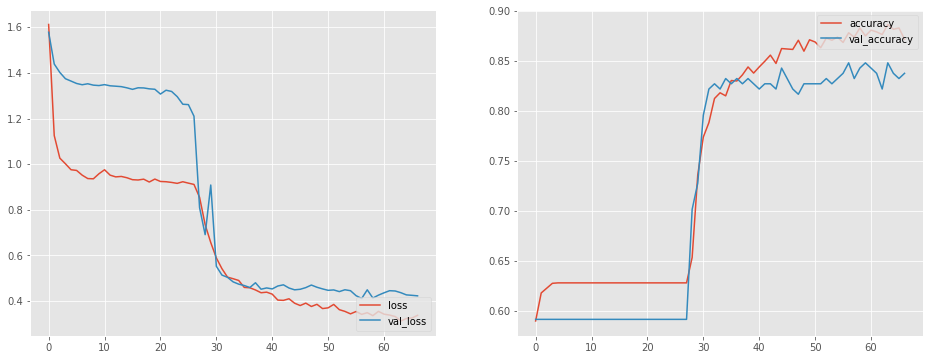

In [34]:
def plot_training(history):
    plt.style.use('ggplot')
    x = range(len(history.history['loss']))
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(121)
    plot1 = ax1.plot(x, history.history['loss'], label = 'loss')
    plot2 = ax1.plot(x, history.history['val_loss'], label = 'val_loss')
    ax1.legend(loc = 'lower right')

    ax2 = fig.add_subplot(122)
    plot3 = ax2.plot(x, history.history['accuracy'], label = 'accuracy')
    plot4 = ax2.plot(x, history.history['val_accuracy'], label = 'val_accuracy')
    ax2.legend(loc = 'upper right')

plot_training(history)

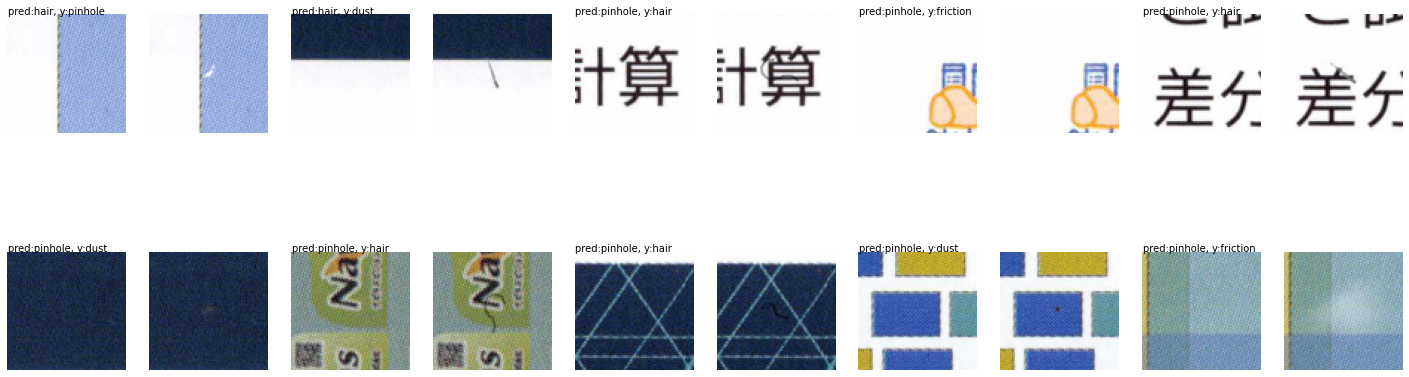

In [35]:
# testデータのうち予測が外れているものを出力

pred = model.predict([x_test[:, 0], x_test[:, 1]])
pred_num = pred.argmax(axis=1)

y = y_test.argmax(axis=1)

cnt = 0
plt.figure(figsize = (25, 8))
plt.title('testデータに対して予測を外したもの')
for i in range(300):
  
  if y[i] != pred_num[i]:
    img1 = x_test[i,0]
    img2 = x_test[i,1]
    plt.subplot(2, 10, 2*cnt+1)
    plt.imshow(img1)
    plt.text(0, 0, f"pred:{class_word[pred_num[i]]}, y:{class_word[y[i]]}")
    plt.axis('off')

    plt.subplot(2, 10, 2*cnt+2)
    plt.imshow(img2)
    plt.axis('off')
    cnt += 1

  if cnt == 10:
    break


ーーーーーーーーーーーーー

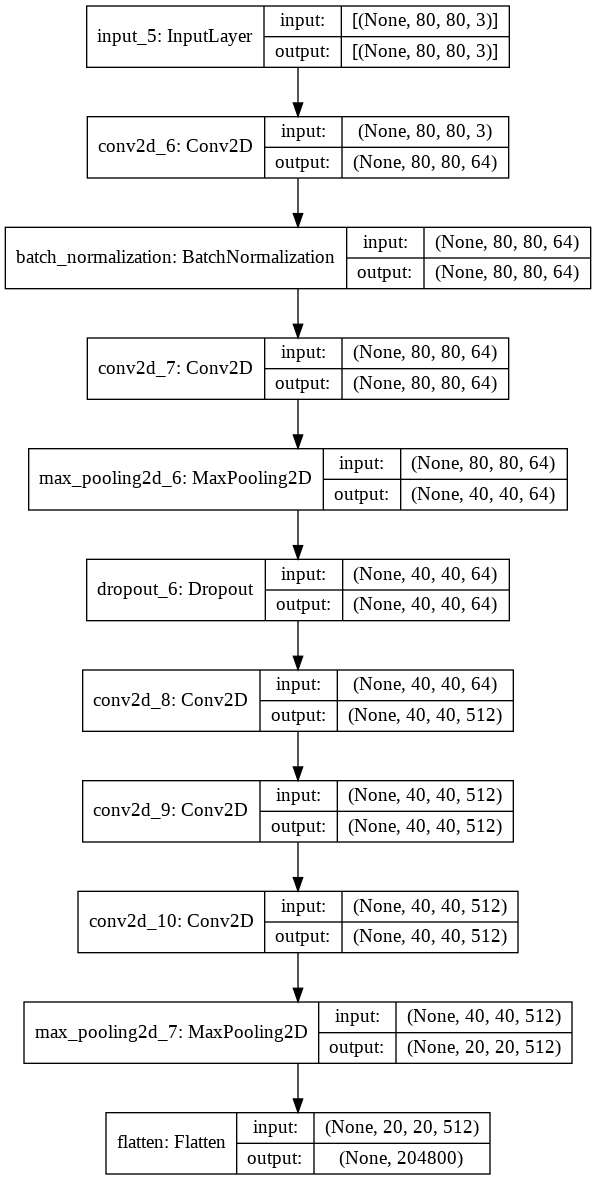

In [ ]:
def build_siamese_model(input_shape=(80,80,3), output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Dropout(0.2)(x)

    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size=(2,2))(x)
    # x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    # x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    # x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size = (2,2))(x)
    # x = Dropout(0.2)(x)

    x = Conv2D(512, (2,2), padding='same', activation='relu')(x)
    x = Conv2D(512, (2,2), padding='same', activation='relu')(x)
    x = Conv2D(512, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size = (2,2))(x)

    pooled_output = Flatten()(x)
    # outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, pooled_output)
    return model

model = build_siamese_model(IMG_SHAPE)
plot_model(model, show_shapes=True)

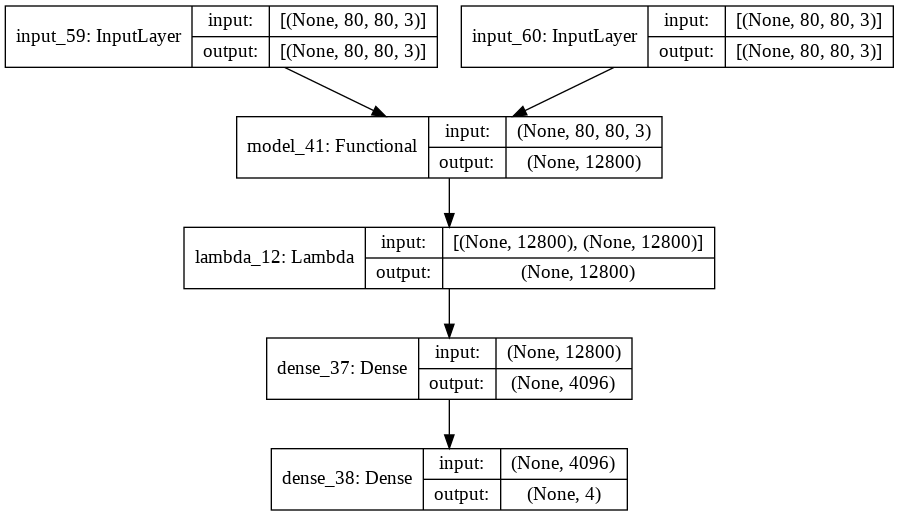

In [ ]:
IMG_SHAPE = (80, 80, 3)

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

def euclidean_distance(vectors):
    (A, B) = vectors
    Squared = K.square(A - B)
    return K.sqrt(K.maximum(Squared, K.epsilon()))

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)
dist = Lambda(euclidean_distance)([modelA, modelB])
# dist = Concatenate()([modelA, modelB])
dist = Dense(4096, activation='relu')(dist)
outputs = Dense(4, activation='softmax')(dist) # 強引に多値分類にしてみる
model = Model(inputs=[imgA, imgB], outputs=outputs)

plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)